# Description of Smaller dataset

In [4]:
import pandas as pd

# Load CSV
df = pd.read_csv("phase_t1.0_U15.0-(0.1)_Mu50.0-(0.1).csv")

print("Initial dataset\n ", df)

# Apply rounding to match Code 1 formatting
df2 = df.round({
    't': 2,
    'U': 2,
    'mu': 3,
    'rho': 4,
    'phi2': 4,
    'energy': 10
    # 'iters' stays as integer
})

print("After rounding\n", df2)
# # Save rounded version
# df.to_csv("code2_rounded.csv", index=False)

Initial dataset
           t  Ubar  Mubar   Density      Phi2      Energy  Iters
0      1.0   0.0    0.0  3.508448  2.762672   -2.762672      1
1      1.0   0.0    0.1  3.587472  2.758786   -3.117533      3
2      1.0   0.0    0.2  3.659333  2.748061   -3.479928      4
3      1.0   0.0    0.3  3.725149  2.731654   -3.849198      4
4      1.0   0.0    0.4  3.785810  2.710462   -4.224786      5
...    ...   ...    ...       ...       ...         ...    ...
75646  1.0  15.0   49.6  3.923532  0.979353 -108.544199     27
75647  1.0  15.0   49.7  3.928223  0.960605 -108.936789     28
75648  1.0  15.0   49.8  3.932737  0.942246 -109.329838     29
75649  1.0  15.0   49.9  3.937079  0.924317 -109.723330     29
75650  1.0  15.0   50.0  3.941251  0.906863 -110.117248     30

[75651 rows x 7 columns]
After rounding
          t  Ubar  Mubar   Density      Phi2      Energy  Iters
0      1.0   0.0    0.0  3.508448  2.762672   -2.762672      1
1      1.0   0.0    0.1  3.587472  2.758786   -3.117533   

In [5]:
(df - df2).abs().max()


t          0.0
Ubar       0.0
Mubar      0.0
Density    0.0
Phi2       0.0
Energy     0.0
Iters      0.0
dtype: float64

# Generation of Bigger Dataset 
## mu=60 and u=25

In [1]:
import pandas as pd
import numpy as np
from scipy.linalg import eigh
from joblib import Parallel, delayed

def get_filename(t, U_end, U_step, mu_end, mu_step, suffix):
    """
    Generate a compact filename like:
    phase_t1.0_U15.0-(0.01)_Mu50.0-(0.001).csv
    """
    return f"phase_t{t:.1f}_U{U_end:.1f}-({U_step})_Mu{mu_end:.1f}-({mu_step}){suffix}"

def initialize_operators(dimf):
    """
        Initialize the annihilation (a), creation (a†), and number (n) operators
        as matrices in a truncated Fock space of size dimf.
        
        Returns:
            aDop: creation operator matrix (a†)
            aop: annihilation operator matrix (a)
            nop: number operator matrix (n = a†a)
            Umat: identity matrix of size dimf (used for φ²·I term)
    """
    aDop = np.zeros((dimf, dimf))
    aop = np.zeros((dimf, dimf))
    nop = np.zeros((dimf, dimf))
    Umat = np.identity(dimf)
    
    for bs in range(dimf):
        for ks in range(dimf):
            if bs == ks:
                nop[bs, ks] = ks                   # Diagonal: n|k⟩ = k|k⟩
            elif bs == ks + 1:
                aDop[bs, ks] = np.sqrt(ks + 1)     # a†|k⟩ = √(k+1)|k+1⟩
            elif bs == ks - 1:
                aop[bs, ks] = np.sqrt(ks)          # a|k⟩ = √k|k-1⟩
    
    return aDop, aop, nop, Umat

def construct_hamiltonian(dimf, t, U, cpc, phi, aDop, aop, nop, Umat):
    """
    Construct the mean-field decoupled single-site Hamiltonian matrix.
    
    H = -t·φ·(a + a†) + t·φ²·I + (U/2)·n(n-1) - μ·n

     ham[i, j] = -t * phi * (aDop[i, j] + aop[i, j]) \     # hopping term (mean-field decoupled)
                        + t * phi**2 * Umat[i, j] \               # φ²·I shift (mean-field correction)
                        + (U / 2.0) * (nop[i, j]**2 - nop[i, j]) \# on-site interaction energy
                        - cpc * nop[i, j]                         # chemical potential term (−μ·n)
            ham[j, i] = ham[i, j]  # Matrix is Hermitian (real symmetric here)
    
    Parameters:
        dimf : basis dimension
        t, U : hopping and interaction parameters
        cpc  : chemical potential μ (called "cpc" in code)
        phi  : current guess for superfluid order parameter φ
        aDop, aop, nop, Umat : operator matrices
    
    Returns:
        ham : Hamiltonian matrix (dimf x dimf)
    """
    ham = np.zeros((dimf, dimf))
    for i in range(dimf):
        for j in range(i + 1):
            ham[i, j] = -t * phi * (aDop[i, j] + aop[i, j]) \
                        + t * phi**2 * Umat[i, j] \
                        + (U / 2.0) * (nop[i, j]**2 - nop[i, j]) \
                        - cpc * nop[i, j]
            ham[j, i] = ham[i, j]   # Matrix is Hermitian (real symmetric here)
    return ham

def mean_field_iteration(dimf, t, U, cpc, aDop, aop, nop, Umat, max_iter=8000, tol=1e-6):
    """
    Self-consistently solve for the ground state at a given (t, U, μ) using mean-field theory.
    
    Steps:
    1. Start with initial φ (superfluid order parameter).
    2. Construct Hamiltonian using φ.
    3. Diagonalize to get ground state |ψ⟩.
    4. Compute:
        - ρ = ⟨ψ|n|ψ⟩ → density
        - φ_new = ⟨ψ|a|ψ⟩ → superfluid order parameter
    5. Iterate until φ converges.
    
    Returns:
        rho     : density ⟨n⟩
        phi²    : square of the superfluid order parameter (⟨a⟩²)
        eigval  : ground state energy
        iter_count : number of iterations to converge
    """


    phi = 0.2  # Initial guess for the superfluid order parameter φ
    for iter_count in range(max_iter):
        ham = construct_hamiltonian(dimf, t, U, cpc, phi, aDop, aop, nop, Umat)
        eigvals, eigvecs = eigh(ham)  # Diagonalize Hamiltonian
        
        ground_state = eigvecs[:, 0]  # Take the ground state |ψ⟩

         # Compute φ_new = ⟨ψ|a|ψ⟩ and ρ = ⟨ψ|n|ψ⟩
        phinew = np.sum(ground_state[:, None] * ground_state[None, :] * aDop)
        rho = np.sum(ground_state[:, None] * ground_state[None, :] * nop)


        # Check for convergence
        if abs(phinew - phi) < tol:
            return rho, phinew**2, eigvals[0], iter_count
        phi = phinew

    # If not converged, return anyway
    return rho, phinew**2, eigvals[0], max_iter

# def main():
#     dimf = 6  # Size of Fock basis (cutoff at max 5 particles per site)

#     t = 1.0   # Hopping amplitude (can be fixed to 1 without loss of generality)
#     U = 5.83  # On-site interaction strength

#     # Note: In this code, U and cpc are already in units of Ū = U / zt and μ̄ = μ / zt
#     # So there's no need to explicitly divide by zt again

#     cpc_start, cpc_end, cps = -5.0, 50.0, 0.01  # μ (cpc) range and step
#     suffix = ".dat"  # Output file extension
    
#     filename = get_filename(t, U, suffix)
#     aDop, aop, nop, Umat = initialize_operators(dimf)


    
#     with open(filename, "w") as f:
#         cpc = cpc_start
#         while cpc <= cpc_end:

#             # For each μ̄, solve the mean-field self-consistent problem
#             rho, rhos, eigval, iter_count = mean_field_iteration(dimf, t, U, cpc, aDop, aop, nop, Umat)
            
            
#             # Print and save results: t, Ū, μ̄, ρ, φ², ground state energy, iterations
#             result = f"{t:.2f} {U:.2f} {cpc:.3f} {rho:.4f} {rhos:.4f} {eigval:.10f} {iter_count}\n"
#             print(result, end="")
#             f.write(result)

#             # Increment μ
#             cpc += cps



def main():
    dimf = 6               # Size of Fock basis
    t = 1.0                # Hopping amplitude (fixed to 1)
    
    # Sweep ranges
    # Ū values
    U_start = 0.0
    U_end = 25.0
    U_step = 0.1
    
    # Calculate number of points
    num_U_points = int((U_end - U_start) / U_step) + 1
    U_list = np.linspace(U_start, U_end, num_U_points)

    
    # μ̄ values
    mu_start = -5.0
    mu_end = 60.0
    mu_step = 0.1

    # Calculate the number of points needed (inclusive of both ends)
    num_mu_points = int((mu_end - mu_start) / mu_step) + 1
    mu_list = np.linspace(mu_start, mu_end, num_mu_points)

    suffix = ".csv"
    filename = get_filename(t, U_end, U_step, mu_end, mu_step, suffix)

    aDop, aop, nop, Umat = initialize_operators(dimf)
    results = []

    # for U in U_list:
    #     for mu in mu_list:
    #         rho, phi2, energy, iter_count = mean_field_iteration(
    #             dimf, t, U, mu, aDop, aop, nop, Umat
    #         )

            
    #         results.append([t, U, mu, rho, phi2, energy, iter_count])

    #         # print(f"{U:.3f} {mu:.3f} {rho:.4f} {phi2:.4f} {energy:.6f}")

    # Function to evaluate one grid point (μ̄, Ū)
    def run_single_point(U, mu):
        rho, phi2, energy, iters = mean_field_iteration(dimf, t, U, mu, aDop, aop, nop, Umat)
        return [t, U, mu, rho, phi2, energy, iters]

    # Parallel evaluation of grid
    results = Parallel(n_jobs=-1, verbose=10)(
        delayed(run_single_point)(U, mu)
        for U in U_list
        for mu in mu_list
    )

    # Save to CSV
    df = pd.DataFrame(results, columns=["t", "Ubar", "Mubar", "Density", "Phi2", "Energy", "Iters"])
    print(df)
    df.to_csv(filename, index=False)
    print(f"\n✅ Saved phase diagram data to: {filename}")

if __name__ == "__main__":
    main()


<>:46: SyntaxWarning: invalid escape sequence '\ '
<>:46: SyntaxWarning: invalid escape sequence '\ '
C:\Users\DELL\AppData\Local\Temp\ipykernel_9896\418186622.py:46: SyntaxWarning: invalid escape sequence '\ '
  ham[i, j] = -t * phi * (aDop[i, j] + aop[i, j]) \     # hopping term (mean-field decoupled)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19190668155457707s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  73 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04050612449645996s.) Setting batch_

          t  Ubar  Mubar       Density          Phi2        Energy  Iters
0       1.0   0.0   -5.0  1.048576e-14  1.048576e-14  2.097152e-13      8
1       1.0   0.0   -4.9  1.508449e-14  1.508449e-14  2.882646e-13      8
2       1.0   0.0   -4.8  2.186340e-14  2.186340e-14  3.987884e-13      8
3       1.0   0.0   -4.7  3.193733e-14  3.193733e-14  5.553901e-13      8
4       1.0   0.0   -4.6  4.703477e-14  4.703477e-14  7.788958e-13      8
...     ...   ...    ...           ...           ...           ...    ...
163396  1.0  25.0   59.6  3.000000e+00  8.530376e-13 -1.038000e+02     21
163397  1.0  25.0   59.7  3.000000e+00  7.586920e-13 -1.041000e+02     21
163398  1.0  25.0   59.8  3.000000e+00  6.791729e-13 -1.044000e+02     21
163399  1.0  25.0   59.9  3.000000e+00  6.119027e-13 -1.047000e+02     21
163400  1.0  25.0   60.0  3.000000e+00  5.548081e-13 -1.050000e+02     21

[163401 rows x 7 columns]

✅ Saved phase diagram data to: phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv


# All Regression Models and MLP ( same as smaller dataset as in superfluid-mott notebook )
models = {
       
    "LogReg-Poly2": logreg_poly2,  
    "SVM-RBF": svm_rbf,
    "RF-Shallow": rf_shallow,
    "RandomForest": rf,
    "MLP": mlp,
    "SVM": svm
}
6 models

## Logistic Regression 
with low-degree polynomial features 
(smooth boundary)
## SVM with RBF kernel
(smooth boundary, good generalization with proper C/gamma)
## RandomForest shallow 
(to avoid overfitting)
## rf 
= RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
## mlp 
= Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])
## svm 
= Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="poly", degree=3, C=1.0))
    ])



📊 Classification Report for LogReg-Poly2:
              precision    recall  f1-score   support

           0     0.8399    0.7846    0.8113     24363
           1     0.7099    0.7791    0.7429     16488

    accuracy                         0.7824     40851
   macro avg     0.7749    0.7818    0.7771     40851
weighted avg     0.7875    0.7824    0.7837     40851


📊 Classification Report for SVM-RBF:
              precision    recall  f1-score   support

           0     0.8375    0.9599    0.8945     24363
           1     0.9244    0.7248    0.8125     16488

    accuracy                         0.8650     40851
   macro avg     0.8809    0.8423    0.8535     40851
weighted avg     0.8725    0.8650    0.8614     40851


📊 Classification Report for RF-Shallow:
              precision    recall  f1-score   support

           0     0.9762    0.9592    0.9676     24363
           1     0.9412    0.9655    0.9532     16488

    accuracy                         0.9617     40851
   mac

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classif

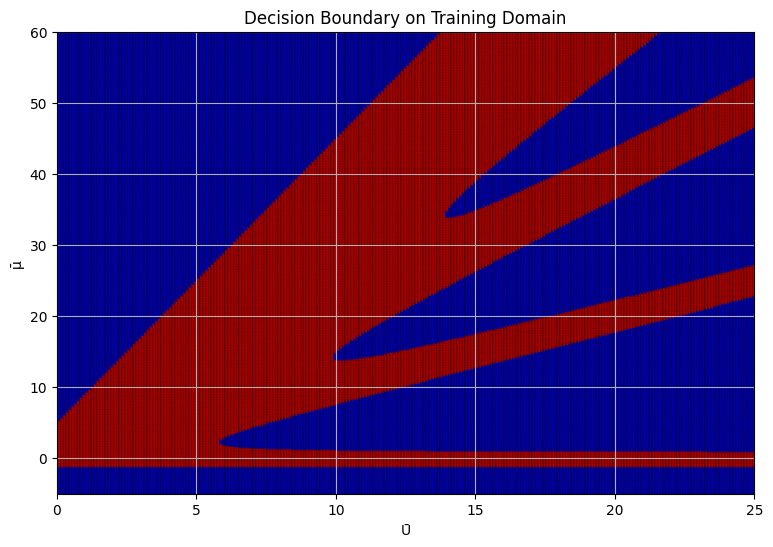

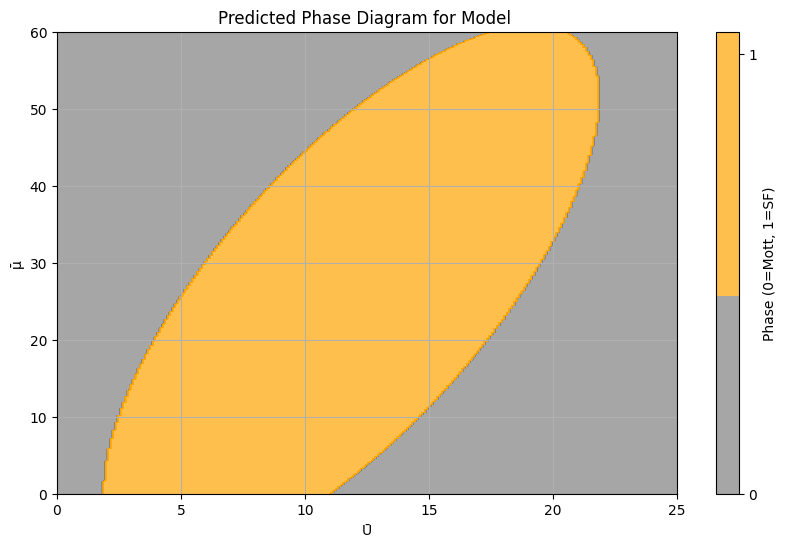


📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.8426    0.7887    0.8148     87410
           1     0.7325    0.7970    0.7634     63441

    accuracy                         0.7922    150851
   macro avg     0.7875    0.7929    0.7891    150851
weighted avg     0.7963    0.7922    0.7932    150851



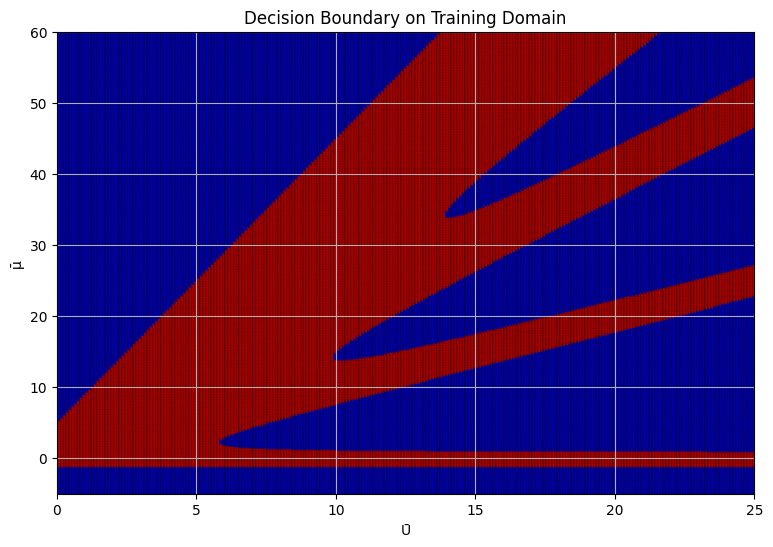

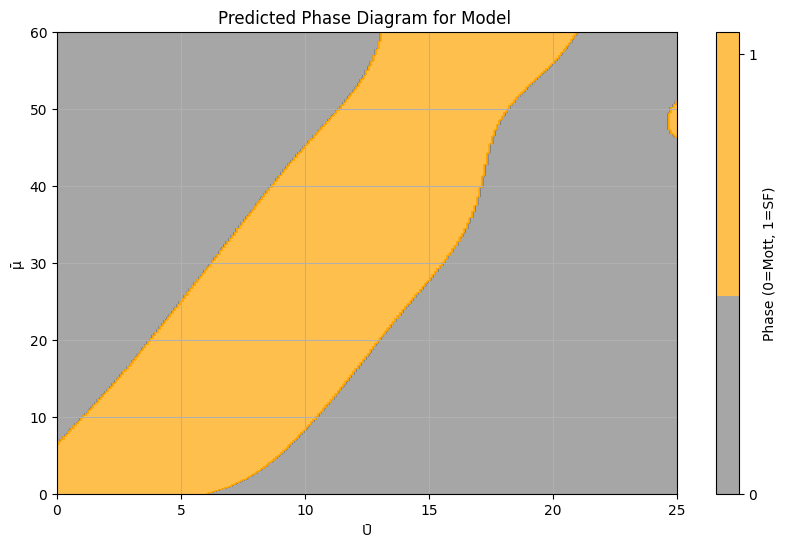


📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.8383    0.9547    0.8927     87410
           1     0.9229    0.7462    0.8252     63441

    accuracy                         0.8670    150851
   macro avg     0.8806    0.8505    0.8590    150851
weighted avg     0.8739    0.8670    0.8643    150851



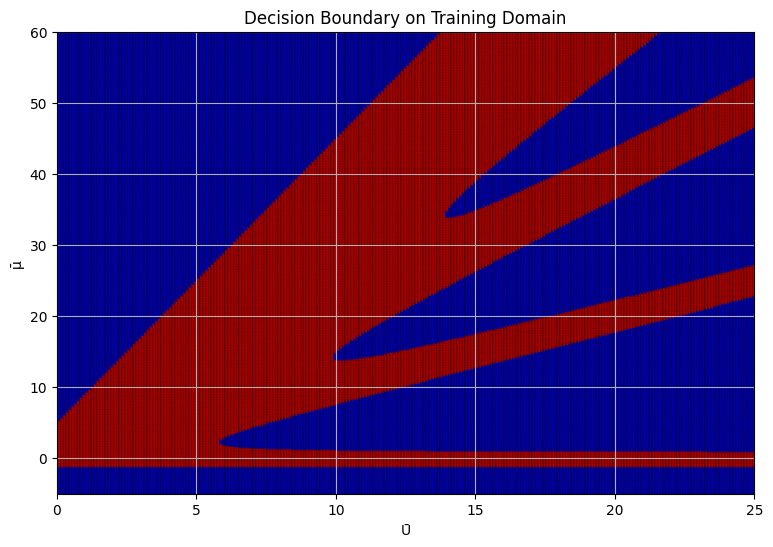

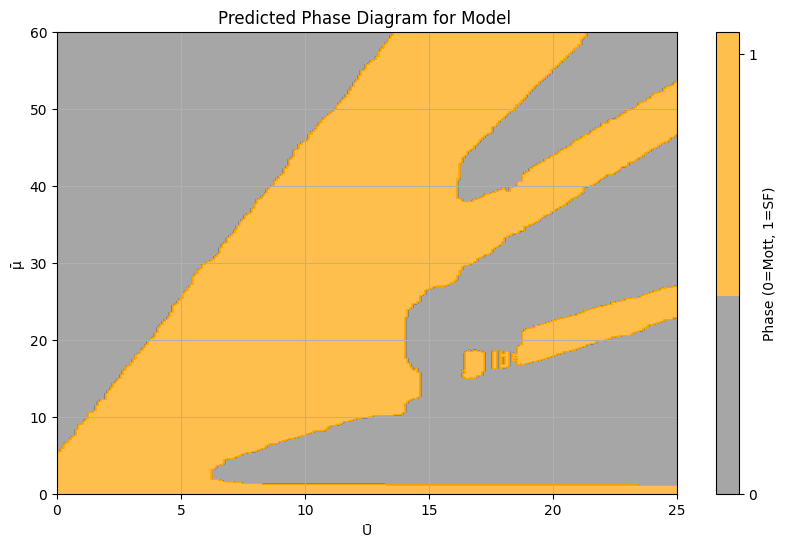


📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9774    0.9565    0.9668     87410
           1     0.9418    0.9695    0.9554     63441

    accuracy                         0.9620    150851
   macro avg     0.9596    0.9630    0.9611    150851
weighted avg     0.9624    0.9620    0.9620    150851



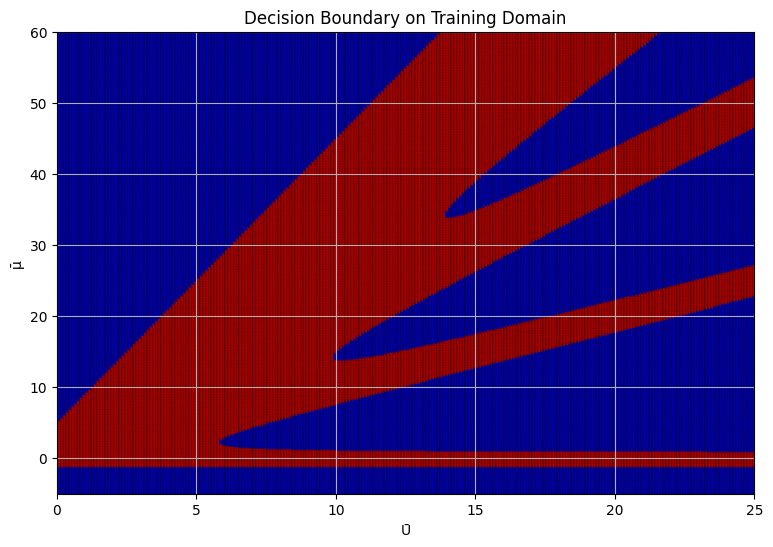

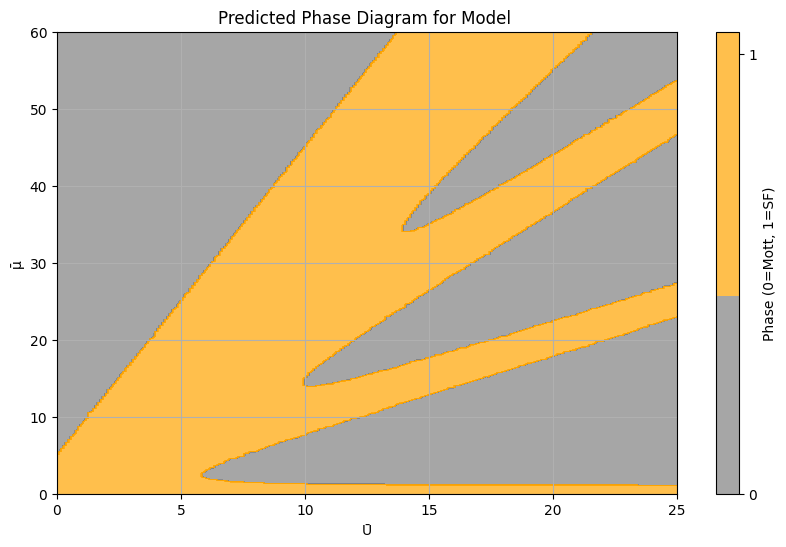


📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9987    0.9985    0.9986     87410
           1     0.9980    0.9982    0.9981     63441

    accuracy                         0.9984    150851
   macro avg     0.9983    0.9984    0.9984    150851
weighted avg     0.9984    0.9984    0.9984    150851



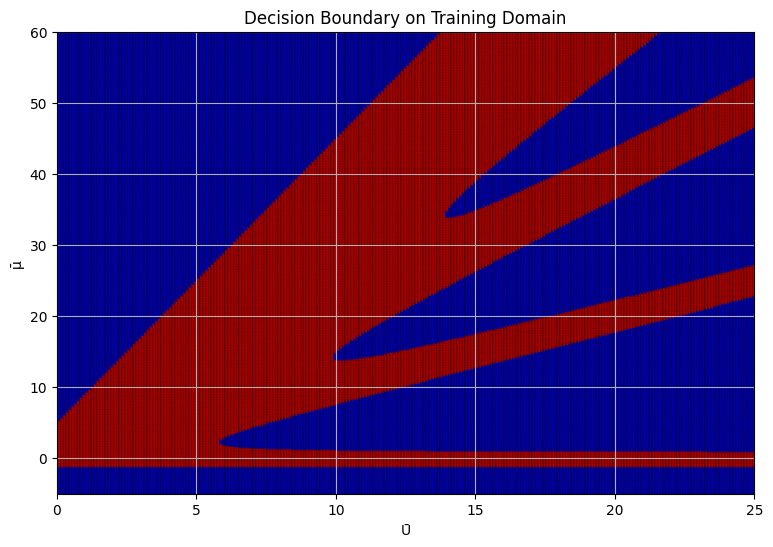

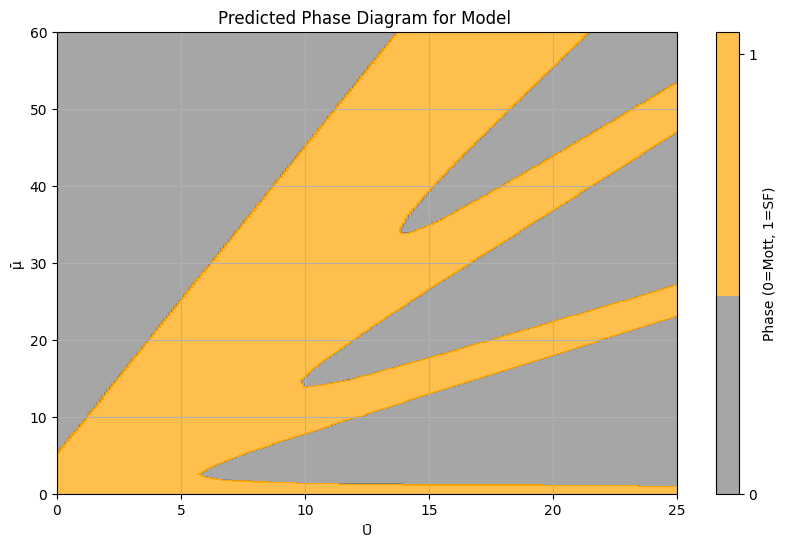


📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9881    0.9986    0.9933     87410
           1     0.9981    0.9834    0.9907     63441

    accuracy                         0.9922    150851
   macro avg     0.9931    0.9910    0.9920    150851
weighted avg     0.9923    0.9922    0.9922    150851



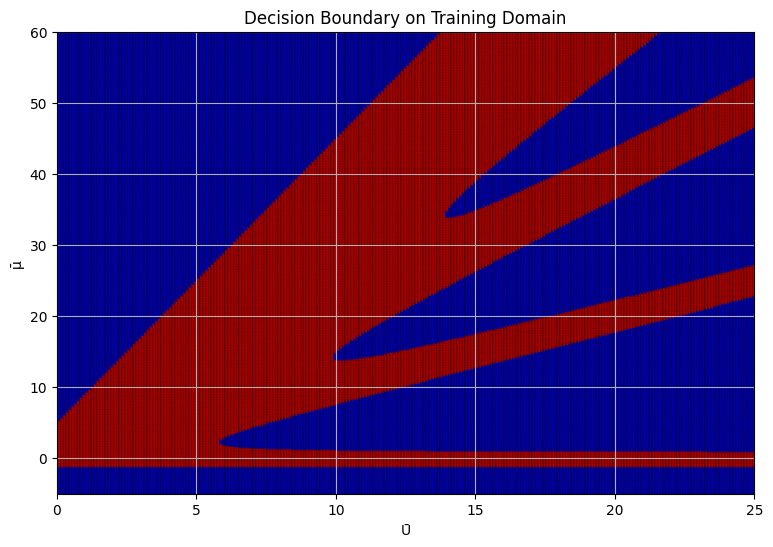

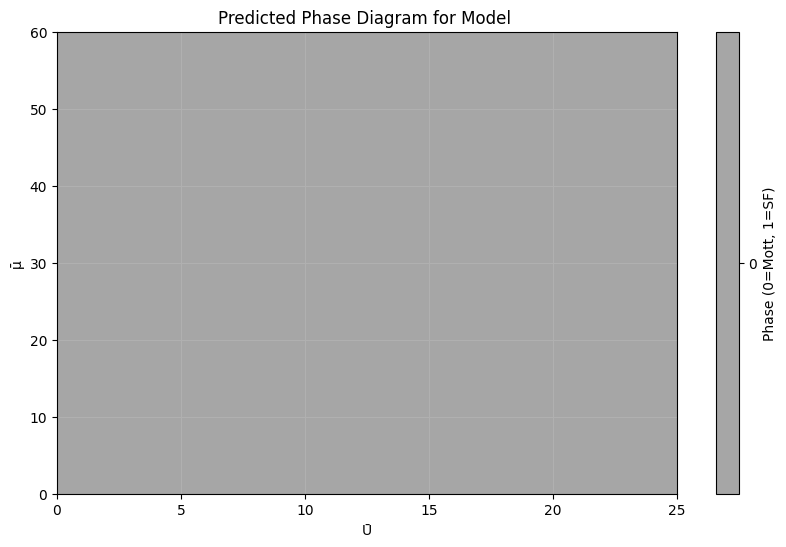


📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.5794    1.0000    0.7337     87410
           1     0.0000    0.0000    0.0000     63441

    accuracy                         0.5794    150851
   macro avg     0.2897    0.5000    0.3669    150851
weighted avg     0.3358    0.5794    0.4252    150851



C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classif

In [1]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
logreg_poly2 = Pipeline(steps=[
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
])

# (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
svm_rbf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
])

# (C) RandomForest shallow (to avoid overfitting)
rf_shallow = RandomForestClassifier(
    n_estimators=300, max_depth=10, min_samples_leaf=5,
    random_state=42, n_jobs=-1
)

rf = RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

svm = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="poly", degree=3, C=1.0))
    ])
models = {
    "LogReg-Poly2": logreg_poly2,
    "SVM-RBF": svm_rbf,
    "RF-Shallow": rf_shallow,
    "RandomForest": rf,
    "MLP": mlp,
    "SVM": svm
}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))


for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    # ---------- 4) Plot decision boundary on training domain ----------
    # def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    #     x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    #     y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    #     xx, yy = np.meshgrid(
    #         np.linspace(x_min, x_max, grid_res),
    #         np.linspace(y_min, y_max, grid_res)
    #     )
    #     grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    #     Z = model.predict(grid_df).reshape(xx.shape)
    
    #     plt.figure(figsize=(9, 6))
    #     plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
    #     plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    #     plt.xlabel("Ū")
    #     plt.ylabel("μ̄")
    #     plt.title(title)
    #     plt.grid(True)
    #     plt.show()
    
    # plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=600, save_name=None):
        x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
        y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, grid_res),
            np.linspace(y_min, y_max, grid_res)
        )
        grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
        Z = model.predict(grid_df).reshape(xx.shape)
    
        plt.figure(figsize=(9, 6))
        plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.5)
        plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
        plt.xlabel("Ū")
        plt.ylabel("μ̄")
        plt.title(title)
        plt.grid(True)
        
        if save_name:
            plt.savefig(save_name, dpi=600, bbox_inches='tight')
        plt.show()

    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 25.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model (Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


In [ ]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# Updated MLP (Scikit-learn)
# =========================
mlp_tuned = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(128, 64, 32),
        activation='relu',
        solver='adam',
        alpha=1e-4,                # L2 regularization
        learning_rate_init=5e-4,   # Lower learning rate
        max_iter=500,
        early_stopping=True,       # built-in in sklearn
        n_iter_no_change=20,
        validation_fraction=0.15,
        random_state=42
    ))
])

# =========================
# Updated Keras Model
# =========================
def create_keras_model():
    model = keras.Sequential([
        keras.layers.Input(shape=(2,)),
        keras.layers.Dense(128, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(1e-4)),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

keras_nn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KerasClassifier(
        model=create_keras_model,
        epochs=200,
        batch_size=64,
        verbose=0,
        validation_split=0.15,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
        ]
    ))
])

# --- TabNet (optional, needs pip install pytorch-tabnet) ---
tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
    # "MLP-Tuned": mlp_tuned,
    # "Keras-NN": keras_nn
    # "TabNet": tabnet  # Remove if you don't want extra install

}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Phase Diagram of the actual dataset",save_name=f"decision_boundary_{i}.png")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 25.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


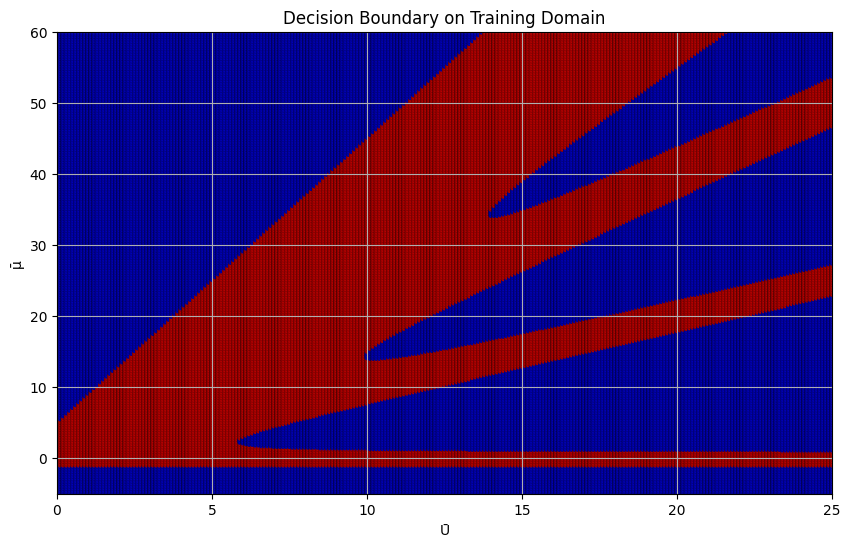

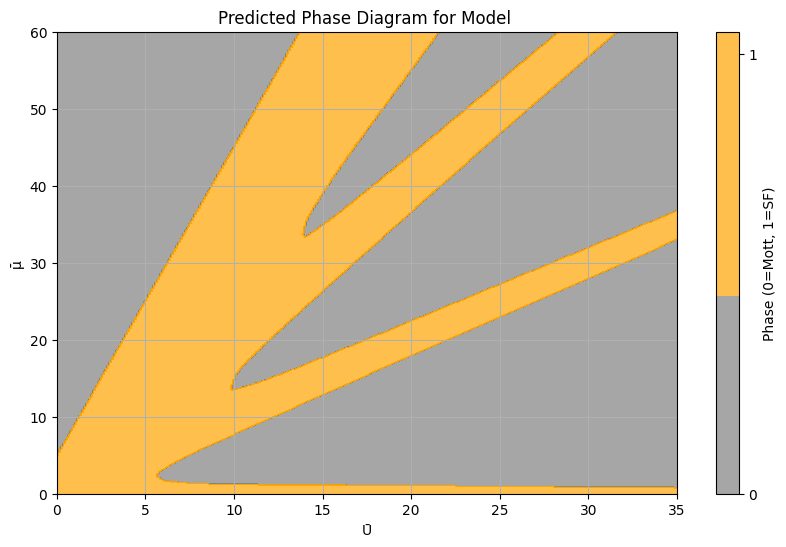


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9946    0.9991    0.9968     87410
           1     0.9987    0.9925    0.9956     63441

    accuracy                         0.9963    150851
   macro avg     0.9966    0.9958    0.9962    150851
weighted avg     0.9963    0.9963    0.9963    150851



In [7]:
clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"

plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain",,save_name=f"decision_boundary_{i}.png")

# ---------- 5) Predict on an extended grid (extrapolation) ----------
U_min, U_max = 0.0, 35.0   # extend beyond training range
mu_min, mu_max = 0.0, 60.0
U_step, mu_step = 0.1, 0.1

U_vals = np.arange(U_min, U_max + U_step, U_step)
mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)

grid_ext = pd.DataFrame({
    "Ubar": U_grid.ravel(),
    "Mubar": mu_grid.ravel()
})

pred_ext = clf.predict(grid_ext)
# if name == "TabNet":
#     pred_ext = model.predict(grid_ext.values)
# else:
#     pred_ext = model.predict(grid_ext)
phase_map = pred_ext.reshape(U_grid.shape)

plt.figure(figsize=(10, 6))
plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
plt.clim(-0.5, 1.5)
plt.xlabel("Ū")
plt.ylabel("μ̄")
plt.title("Predicted Phase Diagram for Model ")
plt.grid(True)
plt.show()

# ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
# Only compare inside the original data domain (U≤15, μ≤50)
mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
grid_in_domain = grid_ext[mask_domain].copy()
pred_in_domain = clf.predict(grid_in_domain)
  
# if name == "TabNet":
#     pred_in_domain = model.predict(grid_in_domain.values)
# else:
#     pred_in_domain = model.predict(grid_in_domain)

# Build true labels by nearest neighbor lookup on your dataset (coarse but works)
# Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
df_lookup = df.copy()
df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]

grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values

# Drop NaNs (grid points that don't map exactly to a dataset point)
valid = ~pd.isna(true_labels)
true_labels = true_labels[valid].astype(int)
pred_labels = pred_in_domain[valid]

print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
print(classification_report(true_labels, pred_labels, digits=4))


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9889    0.9984    0.9936     24363
           1     0.9976    0.9835    0.9905     16488

    accuracy                         0.9924     40851
   macro avg     0.9933    0.9910    0.9921     40851
weighted avg     0.9924    0.9924    0.9924     40851



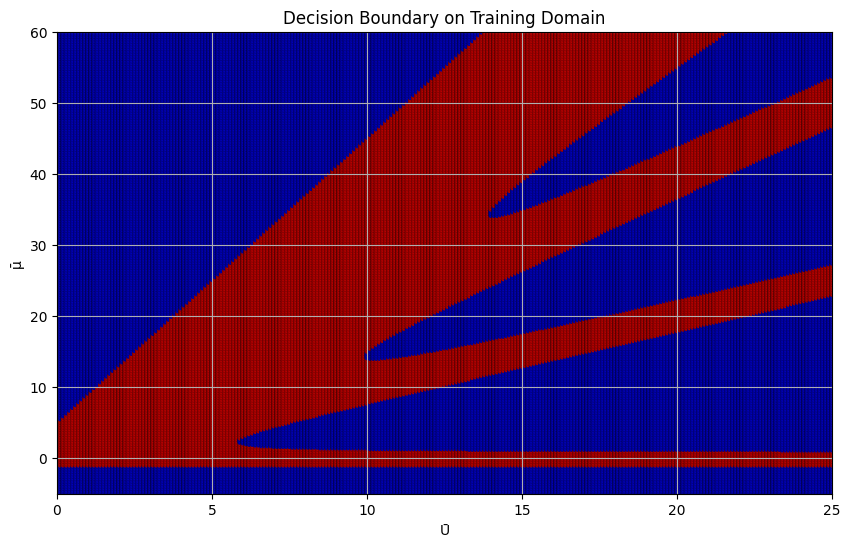

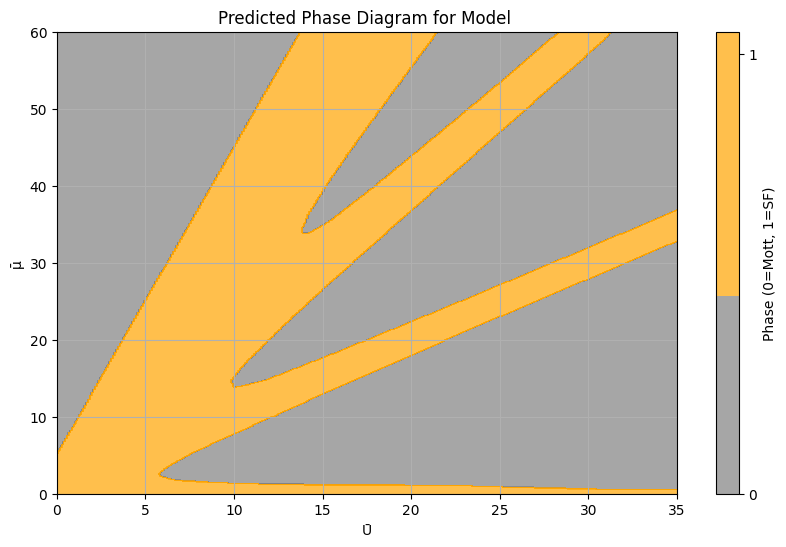


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9881    0.9986    0.9933     87410
           1     0.9981    0.9834    0.9907     63441

    accuracy                         0.9922    150851
   macro avg     0.9931    0.9910    0.9920    150851
weighted avg     0.9923    0.9922    0.9922    150851



In [11]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


# Different Labelling Method with both Phi and Rho in consideration


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9889    0.9984    0.9936     24363
           1     0.9976    0.9835    0.9905     16488

    accuracy                         0.9924     40851
   macro avg     0.9933    0.9910    0.9921     40851
weighted avg     0.9924    0.9924    0.9924     40851



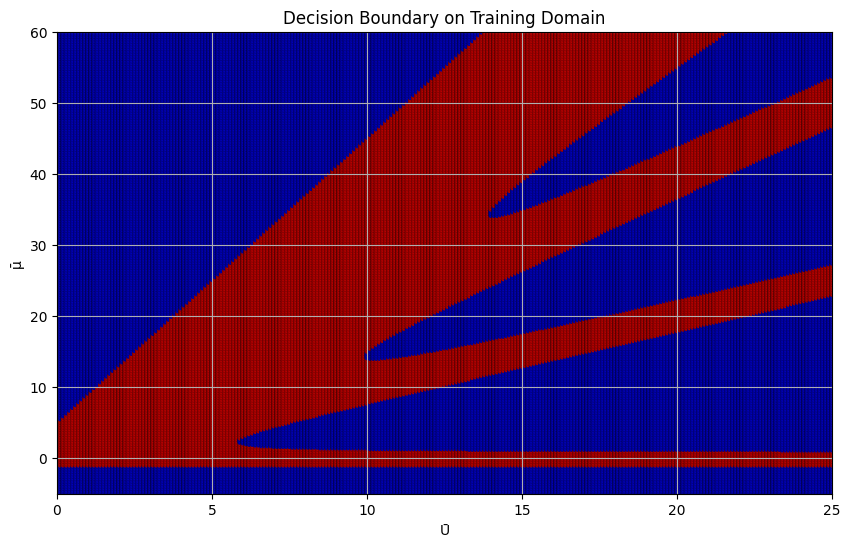

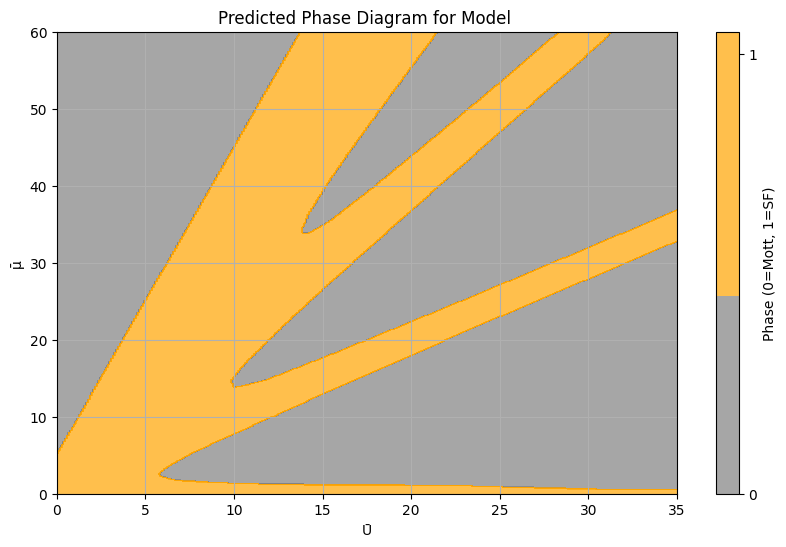


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9881    0.9986    0.9933     87410
           1     0.9981    0.9834    0.9907     63441

    accuracy                         0.9922    150851
   macro avg     0.9931    0.9910    0.9920    150851
weighted avg     0.9923    0.9922    0.9922    150851



In [3]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# Apply physics-based labeling
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9889    0.9984    0.9936     24363
           1     0.9976    0.9835    0.9905     16488

    accuracy                         0.9924     40851
   macro avg     0.9933    0.9910    0.9921     40851
weighted avg     0.9924    0.9924    0.9924     40851



C:\Users\DELL\AppData\Local\Temp\ipykernel_34072\2062884605.py:226: RuntimeWarning: overflow encountered in exp
  return f0 + A / (1.0 + np.exp(s*(x - t)))


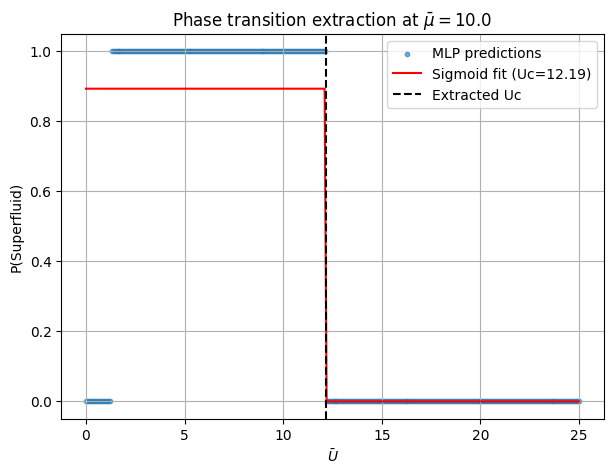

Extracted critical Uc at mu=10.00: 12.191583608611271


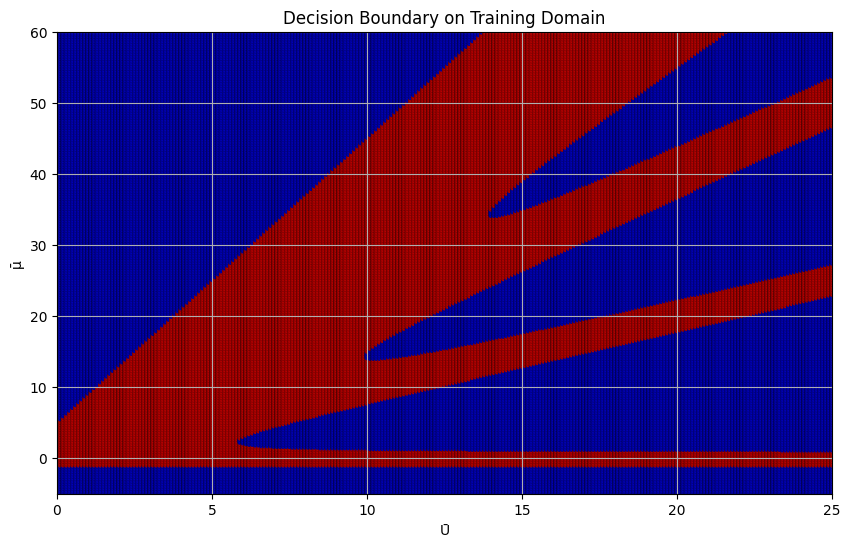

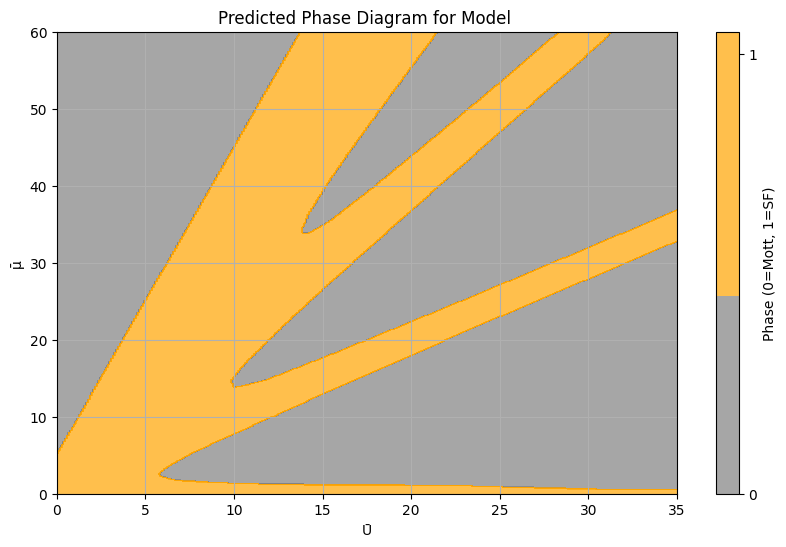


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.9881    0.9986    0.9933     87410
           1     0.9981    0.9834    0.9907     63441

    accuracy                         0.9922    150851
   macro avg     0.9931    0.9910    0.9920    150851
weighted avg     0.9923    0.9922    0.9922    150851



In [2]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# Apply physics-based labeling
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- Sigmoid function for fitting ---
def sigmoid(x, f0, A, s, t):
    """
    f0  = offset
    A   = amplitude
    s   = steepness
    t   = critical point (midpoint)
    """
    return f0 + A / (1.0 + np.exp(s*(x - t)))

# --- Function to sweep Ubar and fit sigmoid ---
def extract_transition(model, mu_fixed, U_min=0.0, U_max=25.0, step=0.1):
    # Sweep Ubar at fixed mu
    U_vals = np.arange(U_min, U_max+step, step)
    X_sweep = pd.DataFrame({"Ubar": U_vals, "Mubar": [mu_fixed]*len(U_vals)})
    
    # Predict probability of SF
    y_probs = model.predict(X_sweep)
    if y_probs.ndim > 1:  # if shape (N,1)
        y_probs = y_probs.ravel()
    
    # Fit sigmoid
    try:
        popt, _ = curve_fit(sigmoid, U_vals, y_probs,
                            p0=[0.0, 1.0, 1.0, np.median(U_vals)],
                            maxfev=10000)
        f0, A, s, Uc = popt
    except RuntimeError:
        print(f"⚠️ Sigmoid fit failed at mu={mu_fixed}")
        return None, U_vals, y_probs, None
    
    return Uc, U_vals, y_probs, popt
    
# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))

# --- Plot one example ---
mu_fixed = 10.0   # choose some chemical potential slice
Uc, U_vals, y_probs, popt = extract_transition(models["MLP"], mu_fixed)

plt.figure(figsize=(7,5))
plt.scatter(U_vals, y_probs, s=10, alpha=0.6, label="MLP predictions")
if popt is not None:
    plt.plot(U_vals, sigmoid(U_vals, *popt), 'r-', label=f"Sigmoid fit (Uc={Uc:.2f})")
plt.axvline(Uc, color="k", linestyle="--", label="Extracted Uc")
plt.xlabel(r"$\bar U$")
plt.ylabel("P(Superfluid)")
plt.title(fr"Phase transition extraction at $\bar \mu={mu_fixed}$")
plt.legend()
plt.grid(True)
plt.show()

print(f"Extracted critical Uc at mu={mu_fixed:.2f}: {Uc}")

    
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))

In [ ]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# Label: 1 = Superfluid, 0 = Mott
def label_phase(rho, phi2, tol_rho=1e-3, tol_phi=1e-6):
    """
    Classify phase:
    - Mott insulator if (rho ~ integer) and (phi^2 ~ 0).
    - Superfluid otherwise.
    """
    is_integer_rho = np.isclose(rho, np.round(rho), atol=tol_rho)
    is_zero_phi = phi2 < tol_phi
    
    if is_integer_rho and is_zero_phi:
        return 0  # Mott
    else:
        return 1  # Superfluid

        
# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# # Label: 1 = Superfluid, 0 = Mott
# df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# # Features and target: **only** Ubar, Mubar
# X = df[["Ubar", "Mubar"]].copy()
# y = df["Phase"].copy()

# # Train/test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.25, random_state=42,
#     stratify=y
# )


# Apply physics-based labeling
df["Phase"] = df.apply(lambda row: label_phase(row["Density"], row["Phi2"]), axis=1)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}
from scipy.special import expit
from scipy.optimize import curve_fit

# --- stable sigmoid definition ---
def sigmoid(x, f0, A, s, t):
    return f0 + A * expit(-s*(x - t))

def extract_transition(model, mu_fixed, U_min=0.0, U_max=25.0, step=0.1):
    """Extract critical Uc for a fixed μ using NN predictions + sigmoid fit"""
    U_vals = np.arange(U_min, U_max + step, step)
    grid = pd.DataFrame({"Ubar": U_vals, "Mubar": mu_fixed})
    y_probs = model.predict_proba(grid)[:, 1]  # probability SF

    # initial guess for parameters
    p0 = [0.0, 1.0, 10.0, (U_min+U_max)/2]

    try:
        popt, _ = curve_fit(sigmoid, U_vals, y_probs, p0=p0, maxfev=5000)
        Uc = popt[3]   # transition point
        return Uc, U_vals, y_probs, popt
    except RuntimeError:
        return None, U_vals, y_probs, None

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))


# --- Loop over μ values to build boundary ---
mu_values = np.arange(0, 50.1, 5.0)  # coarse steps first
Uc_list = []

for mu in mu_values:
    Uc, U_vals, y_probs, popt = extract_transition(models["MLP"], mu)
    if Uc is not None:
        Uc_list.append((mu, Uc))

# Convert to dataframe for plotting
Uc_df = pd.DataFrame(Uc_list, columns=["Mubar", "Uc"])

# --- Plot phase boundary ---
plt.figure(figsize=(8,6))
plt.scatter(Uc_df["Uc"], Uc_df["Mubar"], c="red", label="ML-extracted boundary")
plt.xlabel(r"$\bar U$")
plt.ylabel(r"$\bar \mu$")
plt.title("ML-derived SF–MI Phase Boundary")
plt.legend()
plt.grid(True)
plt.show()

print(Uc_df)
    
    
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))

# Reduced training data


📊 Classification Report for MLP:
              precision    recall  f1-score   support

           0     0.9889    0.9984    0.9936     24363
           1     0.9976    0.9835    0.9905     16488

    accuracy                         0.9924     40851
   macro avg     0.9933    0.9910    0.9921     40851
weighted avg     0.9924    0.9924    0.9924     40851



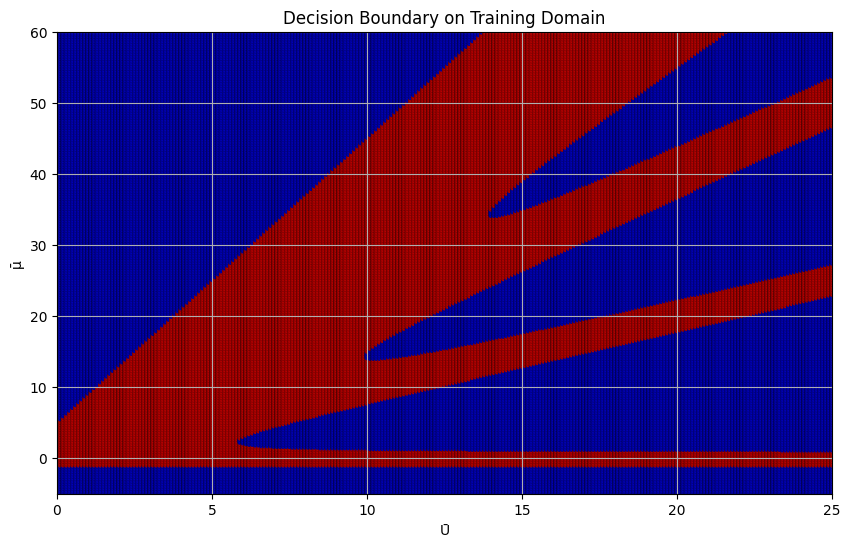

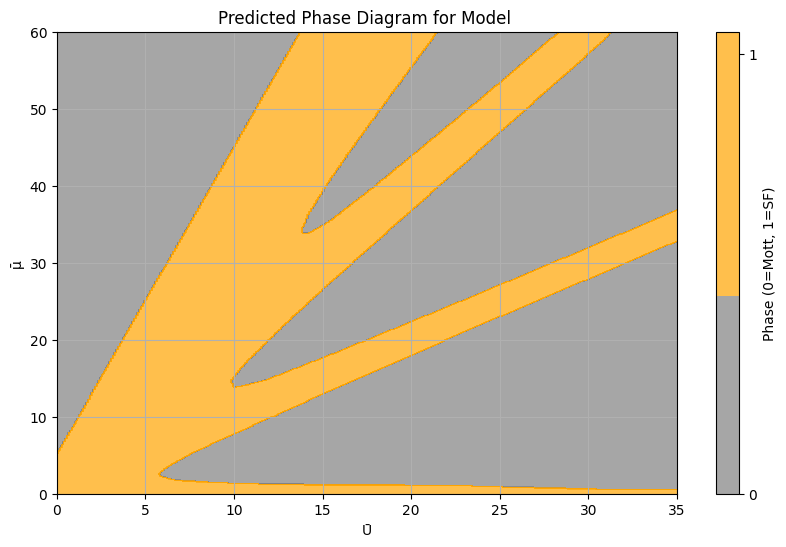


📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):
              precision    recall  f1-score   support

           0     0.8035    1.0000    0.8911      1051
           1     1.0000    0.7929    0.8845      1241

    accuracy                         0.8879      2292
   macro avg     0.9018    0.8965    0.8878      2292
weighted avg     0.9099    0.8879    0.8875      2292



In [5]:
# ================================
# Phase Classification: Clean Setup
# (features = [Ubar, Mubar] only)
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import ListedColormap

import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


# ---------- 1) Load and label ----------
df = pd.read_csv("phase_t1.0_U25.0-(0.1)_Mu60.0-(0.1).csv")

# Label: 1 = Superfluid, 0 = Mott
df["Phase"] = (df["Phi2"] > 1e-6).astype(int)

# Features and target: **only** Ubar, Mubar
X = df[["Ubar", "Mubar"]].copy()
y = df["Phase"].copy()

# --- pick extremes ---
df_extremes = df[
    ((df["Phi2"] < 1e-8) & (np.isclose(df["Density"], np.round(df["Density"]), atol=1e-3)))  # deep MI
    | (df["Phi2"] > 1e-2)  # deep SF
]

# --- pick near-boundary points ---
df_boundary = df[
    (df["Phi2"] > 1e-6) & (df["Phi2"] < 1e-2)   # small but nonzero phi2
]

# --- sample safely ---
n_ext = min(2000, len(df_extremes))
n_bnd = min(5000, len(df_boundary))

df_reduced = pd.concat([
    df_extremes.sample(n_ext, random_state=42),
    df_boundary.sample(n_bnd, random_state=42)
])

# Use this reduced dataset
df = df_reduced.reset_index(drop=True)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, random_state=42,
    stratify=y
)

# ---------- 2) Models (simple, smooth) ----------
# (A) Logistic Regression with low-degree polynomial features (smooth boundary)
# logreg_poly2 = Pipeline(steps=[
#     ("poly", PolynomialFeatures(degree=2, include_bias=False)),  # degree=2 or 3
#     ("scaler", StandardScaler()),
#     ("clf", LogisticRegression(C=0.5, max_iter=2000, solver="lbfgs"))
# ])

# # (B) SVM with RBF kernel (smooth boundary, good generalization with proper C/gamma)
# svm_rbf = Pipeline(steps=[
#     ("scaler", StandardScaler()),
#     ("clf", SVC(kernel="rbf", C=3.0, gamma=0.5, probability=False))  # tweak C, gamma as needed
# ])

# # (C) RandomForest shallow (to avoid overfitting)
# rf_shallow = RandomForestClassifier(
#     n_estimators=300, max_depth=10, min_samples_leaf=5,
#     random_state=42, n_jobs=-1
# )

# rf = RandomForestClassifier(
#         n_estimators=300, random_state=42, n_jobs=-1)
mlp = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=500, random_state=42))
    ])

# svm = Pipeline([
#         ("scaler", StandardScaler()),
#         ("clf", SVC(kernel="poly", degree=3, C=1.0))
#     ])

# # --- Tuned MLP ---
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(hidden_layer_sizes=(128, 64),
#                           activation='relu',
#                           solver='adam',
#                           alpha=1e-3,
#                           learning_rate_init=1e-3,
#                           early_stopping=True,
#                           validation_fraction=0.15,
#                           max_iter=5000,
#                           random_state=42))
# ])

# # --- Keras Sequential NN ---
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu'),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=300,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,  # ✅ reserve 15% of training data for validation
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
#         ]
#     ))
# ])


# # Updated MLP (Scikit-learn)
# # =========================
# mlp_tuned = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", MLPClassifier(
#         hidden_layer_sizes=(128, 64, 32),
#         activation='relu',
#         solver='adam',
#         alpha=1e-4,                # L2 regularization
#         learning_rate_init=5e-4,   # Lower learning rate
#         max_iter=500,
#         early_stopping=True,       # built-in in sklearn
#         n_iter_no_change=20,
#         validation_fraction=0.15,
#         random_state=42
#     ))
# ])

# # =========================
# # Updated Keras Model
# # =========================
# def create_keras_model():
#     model = keras.Sequential([
#         keras.layers.Input(shape=(2,)),
#         keras.layers.Dense(128, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(64, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dropout(0.2),
#         keras.layers.Dense(32, activation='relu',
#                            kernel_regularizer=keras.regularizers.l2(1e-4)),
#         keras.layers.Dense(1, activation='sigmoid')
#     ])
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=5e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy']
#     )
#     return model

# keras_nn = Pipeline([
#     ("scaler", StandardScaler()),
#     ("clf", KerasClassifier(
#         model=create_keras_model,
#         epochs=200,
#         batch_size=64,
#         verbose=0,
#         validation_split=0.15,
#         callbacks=[
#             keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
#             keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
#         ]
#     ))
# ])

# # --- TabNet (optional, needs pip install pytorch-tabnet) ---
# tabnet = TabNetClassifier(verbose=0, seed=42)


models = {
    "MLP": mlp
}

# ---------- 3) Train + Evaluate ----------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, digits=4))
# ---------- 4) Plot decision boundary on training domain ----------
def plot_decision_boundary(model, X, y, title="Decision Boundary", grid_res=300):
    x_min, x_max = X["Ubar"].min(), X["Ubar"].max()
    y_min, y_max = X["Mubar"].min(), X["Mubar"].max()
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_res),
        np.linspace(y_min, y_max, grid_res)
    )
    grid_df = pd.DataFrame({"Ubar": xx.ravel(), "Mubar": yy.ravel()})
    Z = model.predict(grid_df).reshape(xx.shape)
    # if name == "TabNet":
    #     Z = model.predict(grid_df.values).reshape(xx.shape)
    # else:
    #     Z = model.predict(grid_df).reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.scatter(X["Ubar"], X["Mubar"], c=y, s=10, cmap=ListedColormap(['blue', 'red']), edgecolor='k', linewidth=0.2)
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title(title)
    plt.grid(True)
    plt.show()

for i in models:
    # Choose your favorite model (often SVM-RBF or LogReg-Poly2 generalize best)
    clf = models[i]  # or "LogReg-Poly2" or "RF-Shallow"
    
    plot_decision_boundary(clf, X, y, title="Decision Boundary on Training Domain")
    
    # ---------- 5) Predict on an extended grid (extrapolation) ----------
    U_min, U_max = 0.0, 35.0   # extend beyond training range
    mu_min, mu_max = 0.0, 60.0
    U_step, mu_step = 0.1, 0.1
    
    U_vals = np.arange(U_min, U_max + U_step, U_step)
    mu_vals = np.arange(mu_min, mu_max + mu_step, mu_step)
    U_grid, mu_grid = np.meshgrid(U_vals, mu_vals)
    
    grid_ext = pd.DataFrame({
        "Ubar": U_grid.ravel(),
        "Mubar": mu_grid.ravel()
    })
    
    pred_ext = clf.predict(grid_ext)
    # if name == "TabNet":
    #     pred_ext = model.predict(grid_ext.values)
    # else:
    #     pred_ext = model.predict(grid_ext)
    phase_map = pred_ext.reshape(U_grid.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(U_grid, mu_grid, phase_map, cmap=ListedColormap(['gray', 'orange']), alpha=0.7)
    plt.colorbar(ticks=[0, 1], label="Phase (0=Mott, 1=SF)")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Ū")
    plt.ylabel("μ̄")
    plt.title("Predicted Phase Diagram for Model ")
    plt.grid(True)
    plt.show()
    
    # ---------- 6) OPTIONAL: Evaluate predictions vs ground truth where available ----------
    # Only compare inside the original data domain (U≤15, μ≤50)
    mask_domain = (grid_ext["Ubar"] <= X["Ubar"].max()) & (grid_ext["Mubar"] <= X["Mubar"].max())
    grid_in_domain = grid_ext[mask_domain].copy()
    pred_in_domain = clf.predict(grid_in_domain)
      
    # if name == "TabNet":
    #     pred_in_domain = model.predict(grid_in_domain.values)
    # else:
    #     pred_in_domain = model.predict(grid_in_domain)
    
    # Build true labels by nearest neighbor lookup on your dataset (coarse but works)
    # Create a fast lookup table for (Ubar, Mubar) -> Phase by rounding to 1 decimal (since your grid step is 0.1)
    df_lookup = df.copy()
    df_lookup["Ubar_r"] = df_lookup["Ubar"].round(1)
    df_lookup["Mubar_r"] = df_lookup["Mubar"].round(1)
    lookup = df_lookup.groupby(["Ubar_r", "Mubar_r"])["Phase"].mean().round().astype(int).reset_index()
    lookup = lookup.set_index(["Ubar_r", "Mubar_r"])["Phase"]
    
    grid_in_domain["Ubar_r"] = grid_in_domain["Ubar"].round(1)
    grid_in_domain["Mubar_r"] = grid_in_domain["Mubar"].round(1)
    true_labels = lookup.reindex(list(zip(grid_in_domain["Ubar_r"], grid_in_domain["Mubar_r"]))).values
    
    # Drop NaNs (grid points that don't map exactly to a dataset point)
    valid = ~pd.isna(true_labels)
    true_labels = true_labels[valid].astype(int)
    pred_labels = pred_in_domain[valid]
    
    print("\n📊 Classification Report For Prediction using Model(Extrapolated Grid vs True, within data domain):")
    print(classification_report(true_labels, pred_labels, digits=4))
